# 06 Understanding churn and behavior with metrics

In [1]:
import json
import sqlalchemy
import pandas as pd

from pprint import pprint

In [2]:
# Make a sql connection with sqlalchmey
conn_string = "postgresql://postgres-db/churn?user=postgres&password=password" 
engine = sqlalchemy.create_engine(
    conn_string, connect_args={'options': '-csearch_path={}'.format("socialnet7,public")}
)
conn = engine.connect()
# conn.close()

# Query with Pandas, e.g. list all tables
tables = pd.read_sql_query("SELECT * FROM information_schema.tables;", conn)
tables.head(3)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,churn,socialnet7,active_period,BASE TABLE,None,None,None,None,None,YES,NO,None
1,churn,socialnet7,event_type,BASE TABLE,None,None,None,None,None,YES,NO,None
2,churn,socialnet7,metric_name,BASE TABLE,None,None,None,None,None,YES,NO,None


In [3]:
with open("/app/fightchurn/listings/conf/socialnet7_listings.json", "r") as f: 
    conf = json.loads(f.read())

chap5 = conf["chap5"]

## Dependent Data


### Observations

- 4.6.1 Dataset creation SQL program
- Listing 4.5
- Observations on user churn or not, including other behaviour metrics

In [9]:
chap4 = conf["chap4"]

In [10]:
metric_interval = chap4["list6"]["params"]["%metric_interval"]
from_yyyy_mm_dd = chap4["defaults"]["%from_yyyy-mm-dd"]
to_yyyy_mm_dd = chap4["defaults"]["%to_yyyy-mm-dd"]

metric_interval, from_yyyy_mm_dd, to_yyyy_mm_dd

('7 day', '2020-02-09', '2020-05-10')

In [100]:
query = f"""\

WITH observation_params AS (
    SELECT  
        interval '{metric_interval}' AS metric_period,
        '{from_yyyy_mm_dd}'::timestamp AS obs_start,
        '{to_yyyy_mm_dd}'::timestamp AS obs_end
)

    SELECT 
        metric.account_id, 
        obs.observation_date, 
        obs.is_churn,
        SUM(CASE WHEN metric_name_id=0 THEN metric_value ELSE 0 END) AS like_per_month,
        SUM(CASE WHEN metric_name_id=1 THEN metric_value ELSE 0 END) AS newfriend_per_month,
        SUM(CASE WHEN metric_name_id=2 THEN metric_value ELSE 0 END) AS post_per_month,
        SUM(CASE WHEN metric_name_id=3 THEN metric_value ELSE 0 END) AS adview_per_month,
        SUM(CASE WHEN metric_name_id=4 THEN metric_value ELSE 0 END) AS dislike_per_month,
        SUM(CASE WHEN metric_name_id=5 THEN metric_value ELSE 0 END) AS unfriend_per_month,
        SUM(CASE WHEN metric_name_id=6 THEN metric_value ELSE 0 END) AS message_per_month,
        SUM(CASE WHEN metric_name_id=7 THEN metric_value ELSE 0 END) AS reply_per_month,
        SUM(CASE WHEN metric_name_id=8 THEN metric_value ELSE 0 END) AS account_tenure
      FROM metric
INNER JOIN observation_params AS params
        ON metric_time BETWEEN params.obs_start AND params.obs_end    
INNER JOIN observation AS obs
        ON metric.account_id = obs.account_id
       AND metric.metric_time > (obs.observation_date - params.metric_period)::timestamp    
       AND metric.metric_time <= obs.observation_date::timestamp
  GROUP BY metric.account_id, metric.metric_time, obs.observation_date, obs.is_churn    
  ORDER BY obs.observation_date, metric.account_id

"""
res = pd.read_sql_query(query, conn).sort_values(["account_id", "observation_date"]).reset_index(drop=True)
res.head(6)

,account_id,observation_date,is_churn,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
0,1,2020-02-23,False,2.0,0.0,6.0,1.0,3.0,1.0,6.0,6.0,26.0
1,1,2020-03-23,False,2.0,1.0,6.0,2.0,2.0,2.0,7.0,4.0,54.0
2,1,2020-04-23,False,1.0,1.0,2.0,4.0,4.0,1.0,7.0,3.0,82.0
3,2,2020-03-08,True,67.0,7.0,49.0,124.0,120.0,0.0,0.0,0.0,55.0
4,4,2020-02-24,False,36.0,4.0,27.0,36.0,5.0,1.0,32.0,8.0,25.0
5,4,2020-03-24,False,37.0,8.0,39.0,40.0,9.0,0.0,39.0,3.0,53.0


In [101]:
res.is_churn.value_counts(normalize=True)

False    0.955159
True     0.044841
Name: is_churn, dtype: float64

In [102]:
churn_data = res.copy()
churn_data.shape

(31333, 12)

## Behavior Metrics

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

### 5.1 Metric cohort analysis

> - "metric cohort", a cohort of customers defined by having similar values on a metric 
> - "cohort analysis", comparison of different cohorts on some other measuremenet
> - "churn cohort analysis", comparison of churn rates in different metric cohorts
> - Metric cohorts are groups of observations of a customer metric and churn
>   - they are not the same as groups of customers, because one customer can be observed multiple times

- Listing 5.1
- Cohort Analysis with Python

In [103]:
pprint(chap5["list1"])

{'name': 'cohort_plot',
 'params': {'metric_to_plot': 'post_per_month'},
 'v1': {},
 'v10': {'data_set_path': 'socialnet7/socialnet7_dataset2.csv',
         'metric_to_plot': 'days_since_newfriend'},
 'v11': {'data_set_path': 'socialnet7/socialnet7_dataset2.csv',
         'metric_to_plot': 'reply_per_message'},
 'v12': {'data_set_path': 'socialnet7/socialnet7_dataset2.csv',
         'metric_to_plot': 'like_per_post'},
 'v13': {'data_set_path': 'socialnet7/socialnet7_dataset2.csv',
         'metric_to_plot': 'post_per_message'},
 'v14': {'data_set_path': 'socialnet7/socialnet7_dataset2.csv',
         'metric_to_plot': 'unfriend_per_month'},
 'v15': {'data_set_path': 'socialnet7/socialnet7_dataset2.csv',
         'metric_to_plot': 'newfriend_per_month'},
 'v16': {'data_set_path': 'socialnet7/socialnet7_dataset2.csv',
         'metric_to_plot': 'unfriend_per_newfriend'},
 'v17': {'data_set_path': 'socialnet7/socialnet7_dataset3.csv',
         'metric_to_plot': 'customer_age'},
 'v2': {'da

In [48]:
churn_data.is_churn.sum()
# more than 100 churn data points

1405

In [73]:
def cohort_plot(churn_data, metric_to_plot='', ncohort=10):
    
    # cut data points of the given metric to N quantile 
    groups = pd.qcut(churn_data[metric_to_plot], ncohort, duplicates='drop')
    # N.B. each group should have about > 300 data points
    
    # group by the quantiles, and then average on the given metric
    # cohort_means = churn_data.groupby(groups)[metric_to_plot].mean()
    # group by the quantiles, and then average on churn
    # cohort_churns = churn_data.groupby(groups)['is_churn'].mean()
    
    result = churn_data.groupby(by=groups).agg({
        "is_churn": "mean", metric_to_plot: "mean", "account_id": "count"
    })
    
    # plot the average of each quantile
    plot_frame = pd.DataFrame({metric_to_plot: result[metric_to_plot].values, 'churn_rate': result["is_churn"].values})
    plt.figure(figsize=(8, 4))
    plt.plot(metric_to_plot, 'churn_rate', data=plot_frame, marker='o', color='black', linewidth=2, label=metric_to_plot)
    plt.xlabel('Cohort Average of  "%s"' % metric_to_plot)
    plt.ylabel('Cohort Churn Rate')
    plt.grid()
    plt.gca().set_ylim(bottom=0)
    
    return result

In [66]:
sorted(churn_data.columns.drop(["account_id", "observation_date", "is_churn"]))

['account_tenure',
 'adview_per_month',
 'dislike_per_month',
 'like_per_month',
 'message_per_month',
 'newfriend_per_month',
 'post_per_month',
 'reply_per_month',
 'unfriend_per_month']

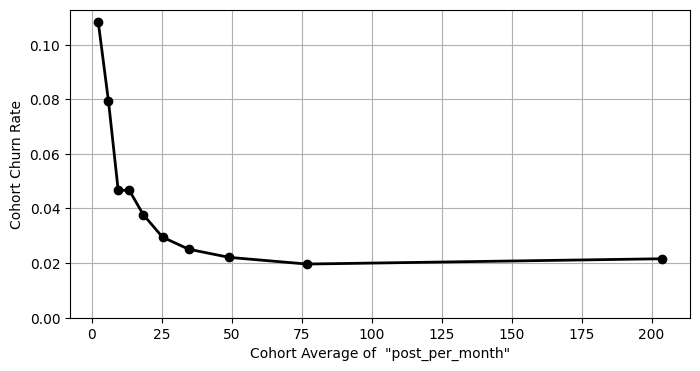

In [75]:
metric = "post_per_month"
_ = cohort_plot(churn_data, metric)

- customers with more than 25 posts per month have about 3% churn rate
- customers with more than 75 posts per month have about 2% churn rate

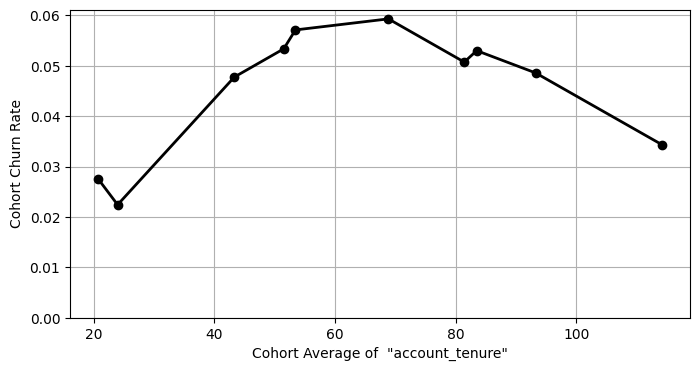

In [76]:
metric = "account_tenure"
plot_data = cohort_plot(churn_data, metric)

- consider number of data points in each quantile cohort, this may not give useful information
  - every cohort should have at least 200 ~ 300 observations
- churn rate is lower for new joiners late joiners
- ...

In [77]:
plot_data
# each cohor does have more than 300 observations

,is_churn,account_tenure,account_id
account_tenure,,,
"(17.999, 22.0]",0.027526,20.748941,3306
"(22.0, 25.0]",0.022410,23.966931,3659
"(25.0, 50.0]",0.047772,43.321324,3747
"(50.0, 52.0]",0.053378,51.510555,3316
"(52.0, 54.0]",0.057133,53.454361,2958
"(54.0, 80.0]",0.059327,68.862385,3270
"(80.0, 82.0]",0.050747,81.445319,2542
"(82.0, 84.0]",0.053017,83.509483,2320
"(84.0, 111.0]",0.048605,93.258626,3333


In [66]:
sorted(churn_data.columns.drop(["account_id", "observation_date", "is_churn"]))

['account_tenure',
 'adview_per_month',
 'dislike_per_month',
 'like_per_month',
 'message_per_month',
 'newfriend_per_month',
 'post_per_month',
 'reply_per_month',
 'unfriend_per_month']

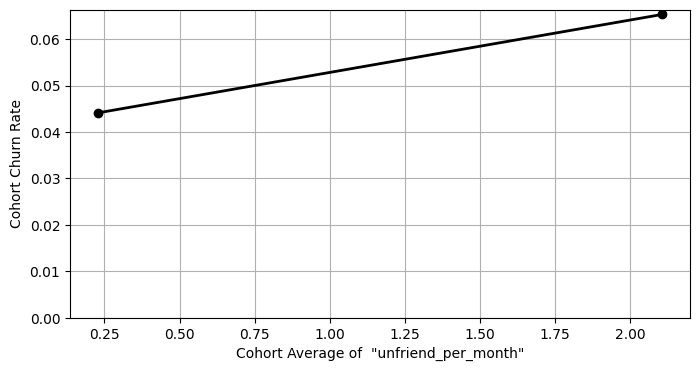

In [80]:
metric = "unfriend_per_month"
plot_data = cohort_plot(churn_data, metric)

### 5.2 Summarizing customer behavior

- 5.2.2 Calculating dataset summary statistics in Python 
- Listing 5.2

In [13]:
import pandas as pd
import numpy as np

In [124]:
tmp = churn_data.drop(columns=["account_id", "is_churn"])

quantiles = {"1%": tmp.quantile(q=0.01), "99%": tmp.quantile(q=0.99)}
summary = (
    tmp.describe().transpose()
    .assign(
        skew=tmp.skew(),
        nonzero=tmp.astype(bool).sum(axis=0) / tmp.shape[0],
        **quantiles
    )[['count','nonzero','mean','std','skew','min','1%','25%','50%','75%','99%','max']]
    .rename(columns=lambda s: s.replace("%", "pct"))
)
summary

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
like_per_month,31333.0,0.993425,102.809849,206.346920,8.290009,0.0,1.0,18.0,44.0,106.0,916.68,5653.0
newfriend_per_month,31333.0,0.912871,7.194460,8.667298,3.787812,0.0,0.0,2.0,5.0,9.0,41.00,162.0
post_per_month,31333.0,0.985255,43.499697,79.422463,9.723007,0.0,0.0,9.0,21.0,48.0,329.68,2384.0
adview_per_month,31333.0,0.978266,41.348482,71.079170,6.147157,0.0,0.0,8.0,20.0,45.0,336.00,1457.0
dislike_per_month,31333.0,0.949542,15.339450,21.976779,4.841534,0.0,0.0,4.0,9.0,18.0,111.00,405.0
unfriend_per_month,31333.0,0.255801,0.293588,0.539168,1.832746,0.0,0.0,0.0,0.0,1.0,2.00,5.0
message_per_month,31333.0,0.962946,30.144321,67.060479,8.111159,0.0,0.0,5.0,12.0,28.0,304.68,1511.0
reply_per_month,31333.0,0.789264,7.964606,22.057363,9.263953,0.0,0.0,1.0,2.0,6.0,98.00,579.0
account_tenure,31333.0,1.000000,61.068777,29.593665,0.241582,18.0,19.0,26.0,54.0,83.0,116.00,116.0


About the summary stats

- If skew is zero, the low and high values are symmetrically distributed
  - If skew is positive, there're more observations higher than the mean
  - If skew is negative, there're more observations smaller than the mean
- Only "account_tenure" is close to symmetrically distributed
- Quatile are the metric values required to find a fixed percentile of the observations below that value
- With "like_per_month" quantiles
  - 50% (from 25% to  75%) of the accounts have between 18 and 106 likes per month
  - 25% with 18 likes, meaning 25% of the observations are less than 18 and 75% are greater than 18
  - 75% with 106 likes, meaning 75% of the observations have less than 106 and 25% have higher than 106

### 5.3 Scoring metrics

> scoring as the normalization or standardization of data

- 5.3.3 Calculating metric scores in Python
- Listing 5.3

In [104]:
import numpy as np

In [105]:
skew_thresh = 4.0
skewed_columns = summary[(summary['skew'] > skew_thresh) & (summary['min'] >= 0)]
skewed_columns
# these are the skewed columns, with the given threshold

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
like_per_month,31333.0,0.993425,3.797733,1.309756,8.290009,0.0,1.0,18.0,44.0,106.0,916.68,5653.0
post_per_month,31333.0,0.985255,3.089984,1.196448,9.723007,0.0,0.0,9.0,21.0,48.0,329.68,2384.0
adview_per_month,31333.0,0.978266,3.021980,1.218843,6.147157,0.0,0.0,8.0,20.0,45.0,336.00,1457.0
dislike_per_month,31333.0,0.949542,2.241344,1.063766,4.841534,0.0,0.0,4.0,9.0,18.0,111.00,405.0
message_per_month,31333.0,0.962946,2.584987,1.250870,8.111159,0.0,0.0,5.0,12.0,28.0,304.68,1511.0
reply_per_month,31333.0,0.789264,1.349369,1.121155,9.263953,0.0,0.0,1.0,2.0,6.0,98.00,579.0


In [106]:
scored = churn_data.copy()\
    .drop(columns=["account_id", "is_churn", "observation_date"])

# iterate the skewed columns
for col in skewed_columns.index:
    # add the columns log scaled
    scored[col] = np.log(1.0 + scored[col])
    
    # subtract the mean and divide by std
    # update summary stats with mean and std from log scaled data
    summary.loc[col, 'mean'] = scored[col].mean()
    summary.loc[col, 'std'] = scored[col].std()

summary.head()

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
like_per_month,31333.0,0.993425,3.797733,1.309756,8.290009,0.0,1.0,18.0,44.0,106.0,916.68,5653.0
newfriend_per_month,31333.0,0.912871,7.194460,8.667298,3.787812,0.0,0.0,2.0,5.0,9.0,41.00,162.0
post_per_month,31333.0,0.985255,3.089984,1.196448,9.723007,0.0,0.0,9.0,21.0,48.0,329.68,2384.0
adview_per_month,31333.0,0.978266,3.021980,1.218843,6.147157,0.0,0.0,8.0,20.0,45.0,336.00,1457.0
dislike_per_month,31333.0,0.949542,2.241344,1.063766,4.841534,0.0,0.0,4.0,9.0,18.0,111.00,405.0


In [107]:
scored.head()

,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
0,1.098612,0.0,1.945910,0.693147,1.386294,1.0,1.945910,1.945910,26.0
1,1.098612,1.0,1.945910,1.098612,1.098612,2.0,2.079442,1.609438,54.0
2,0.693147,1.0,1.098612,1.609438,1.609438,1.0,2.079442,1.386294,82.0
3,4.219508,7.0,3.912023,4.828314,4.795791,0.0,0.000000,0.000000,55.0
4,3.610918,4.0,3.332205,3.610918,1.791759,1.0,3.496508,2.197225,25.0


In [108]:
# update the log scaled data with mean and std from summary
result_scored = ((scored - summary['mean']) / summary['std'])
result_scored.head()

,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
0,-2.060782,-0.830069,-0.956225,-1.910692,-0.803795,1.310188,-0.510905,0.532077,-1.185010
1,-2.060782,-0.714693,-0.956225,-1.578028,-1.074233,3.164898,-0.404155,0.231965,-0.238861
2,-2.370355,-0.714693,-1.664403,-1.158921,-0.594028,1.310188,-0.404155,0.032935,0.707287
3,0.322026,-0.022436,0.687066,1.482007,2.401324,-0.544521,-2.066550,-1.203553,-0.205070
4,-0.142633,-0.368565,0.202450,0.483194,-0.422635,1.310188,0.728709,0.756234,-1.218801


In [120]:
# reattache other data 
result_scored["account_id"] = res["account_id"]
result_scored["is_churn"] = res["is_churn"]
result_scored["observation_date"] = res["observation_date"]

result_scored = result_scored[["account_id", "observation_date", "is_churn", *scored.columns]]
result_scored.head()

,account_id,observation_date,is_churn,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
0,1,2020-02-23,False,-2.060782,-0.830069,-0.956225,-1.910692,-0.803795,1.310188,-0.510905,0.532077,-1.185010
1,1,2020-03-23,False,-2.060782,-0.714693,-0.956225,-1.578028,-1.074233,3.164898,-0.404155,0.231965,-0.238861
2,1,2020-04-23,False,-2.370355,-0.714693,-1.664403,-1.158921,-0.594028,1.310188,-0.404155,0.032935,0.707287
3,2,2020-03-08,True,0.322026,-0.022436,0.687066,1.482007,2.401324,-0.544521,-2.066550,-1.203553,-0.205070
4,4,2020-02-24,False,-0.142633,-0.368565,0.202450,0.483194,-0.422635,1.310188,0.728709,0.756234,-1.218801


In [121]:
result_scored.shape

(31333, 12)

#### 5.3.4 Cohort Analysis with scored metrics

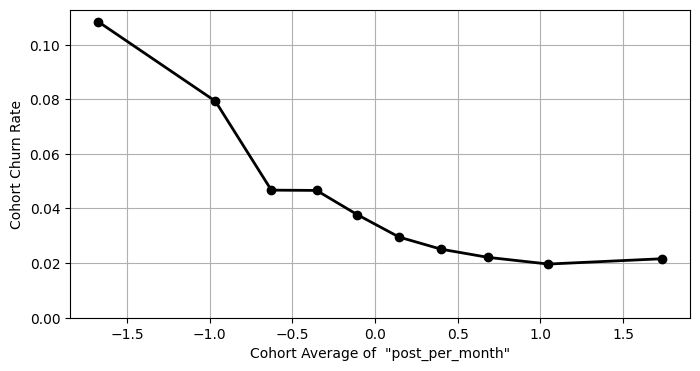

In [112]:
metric = "post_per_month"
plot_df = cohort_plot(result_scored, metric)

- compare with the origial data, scored data shows the changes easier